###  Data Entries: 
0 Bound, 1 Date + Time, 2 Seq No, 3 Lane, 4 Speed, 5 Class, 6 No of Axle, [ Axle Weight, Axle Spacing]

---
### <span style="color:red"> Methods and Procedures </span>


#### Data Cleaning
- Sort the data based on Date > Bound > lane 
- obtain the gap distance 

#### Fitting and Regression
- Find the variation in LDV:HDV ratio across different times of the day
- Find the variation in (Traffic Volume in hour)/(Traffic Volume in day) across different times of the day [Reference](https://medium.com/hal24k-techblog/a-guide-to-generating-probability-distributions-with-neural-networks-ffc4efacd6a4)
- Find the PDF of the vehicle weight of LDV 
- Find the PDF of the vehicle weight of HDV 
- Find the Relation between parameters with the below methods

#### Monte Carlo Simluation
- Set up an environment for simulation. Refer to your IR. 
- Run for 2400 years
- Obtain max load effect. -> Transition to SAP2000

---

### Relationship between each entries: 
 - Time of the day -> Proportion of Vehicle Class
   - Vehicle Class -> Vehicle Speed ? Need to see if there is a relationship or not. 
      - Vehicle Class + Vehicle Speed -> Gap Distance  
        //
   - Vehicle Class -> Axle Number 
      - Axle number -> Total Weight & Axle Weight

Multiple Lasso/Ridge Regression or polynomial regression would be used to draw the relationships of the above figures. 

### Assumptions and Relationships: 
- the Traffic composition relates to the time of the day
- Gap distance between vehicles is determined by the vehicle speed and the vehicle class ie. weight

In [39]:
import pandas as pd
import seaborn as sns

In [ ]:
all_data= pd.read_excel('output.xlsx')
# usecols='A:I'

In [ ]:
# all_data.loc[:,'Seq No':'Class'].head()
all_data['Date + Time'] = pd.to_datetime(all_data['Date + Time'])
all_data['Date'] = pd.to_datetime(all_data['Date + Time']).dt.date
all_data['Date'].unique()

In [ ]:
all_data = all_data.sort_values(['Date','Bound', 'Lane','Seq No'])

#### Calculates the Gap distance

In [ ]:
all_data['Same Bound'] = all_data['Bound'] == all_data['Bound'].shift(1)
all_data['Same Lane'] = all_data['Lane'] == all_data['Lane'].shift(1)    
# if all_data.loc['Bound'].eq(all_data.loc['Bound'].shift(1)) and all_data.loc['Lane'].eq(all_data.loc['Lane'].shift(1)):
#     all_data['Gap Distance'] = all_data['Speed'] * (all_data['Date + Time'].shift(1) - all_data['Date + Time'])
# else:
#     all_data['Gap Distance'] = pd.NA


    

In [ ]:
filter1 = all_data['Same Bound'] == True
filter2 = all_data['Same Lane'] == True
not_filter1 = all_data['Same Bound'] == False
not_filter2 = all_data['Same Lane'] == False

change = all_data['Date + Time'].diff().dt.seconds
# all_data['Speed'] * (all_data['Date + Time'].shift(1) - all_data['Date + Time'])

all_data.loc[filter1 & filter2, 'Gap Distance'] = change
all_data.loc[not_filter1, 'Gap Distance'] = pd.NA
all_data.loc[not_filter2, 'Gap Distance'] = pd.NA

In [ ]:
# all_data = all_data.fillna(all_data['Gap Distance'].mean())

cols = ['Gap Distance']
all_data.loc[:,cols] = all_data.loc[:,cols].bfill()


In [37]:
subset = all_data.drop(columns=['Date + Time','Date']).loc[:,:'No of Axle']
Weight_Gap_Corr = subset.corr()
print(Weight_Gap_Corr)

              Gap Distance  Total Weight     Bound    Seq No      Lane   
Gap Distance      1.000000      0.046639 -0.112323  0.092324  0.043471  \
Total Weight      0.046639      1.000000 -0.031601  0.034114 -0.388749   
Bound            -0.112323     -0.031601  1.000000  0.038872  0.086363   
Seq No            0.092324      0.034114  0.038872  1.000000  0.042279   
Lane              0.043471     -0.388749  0.086363  0.042279  1.000000   
Speed             0.033896     -0.216113 -0.021953 -0.036410  0.401576   
Class             0.041409      0.764752 -0.022125  0.035003 -0.390537   
No of Axle        0.039531      0.827129 -0.024496  0.032235 -0.342704   

                 Speed     Class  No of Axle  
Gap Distance  0.033896  0.041409    0.039531  
Total Weight -0.216113  0.764752    0.827129  
Bound        -0.021953 -0.022125   -0.024496  
Seq No       -0.036410  0.035003    0.032235  
Lane          0.401576 -0.390537   -0.342704  
Speed         1.000000 -0.170976   -0.196007  
Clas

It can be seen that there is not much relationship between Gap distace and Total Weight

There is relationship between speed and lane number, but should not affect the calculation of load effect. 


Class 1 - Motor cycles

Class 2 - Private cars


Class 3 - Light buses

Class 4 - Light Goods Vehicles

Class 5 - Medium Goods Vehicles

Class 6 - Rigid Heavy Goods Vehicles

Class 7 - Articulated Heavy Goods Vehicles

Class 8 - Buses and Coaches

Class 9 - Unclassified

## LDV to HDV Ratio

In [186]:

# HDV
HDV = all_data.loc[(all_data['Class'].astype(int) > 2)| ((all_data['Class'].astype(int) <= 2) & (all_data['Total Weight'].astype(int) > 6000))]
total_trucks = HDV[HDV.columns[0]].count()
# LDV - Private Vehicle and Motorbikes
PV = all_data.loc[(all_data['Class'].astype(int) <= 2) & (all_data['Total Weight'].astype(int) >= 1500) & (all_data['Total Weight'].astype(int) <= 6000) ]
# PV['Total Weight'].mode
total_cars = PV[PV.columns[0]].count()

# LDV - Motorbike
MB = all_data.loc[(all_data['Class'].astype(int) <= 2) & (all_data['Total Weight'].astype(int) < 1500) ]
total_motorbikes = MB[MB.columns[0]].count()

print([total_trucks,total_cars,total_motorbikes])
print(sum([total_trucks,total_cars,total_motorbikes]))

[32483, 29276, 25743]
87502


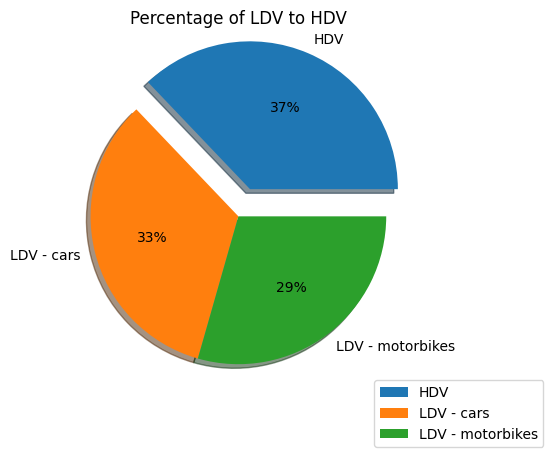

In [197]:
import numpy as np
import matplotlib.pyplot as plt

pie_chart_labels = ['HDV','LDV - cars','LDV - motorbikes']
myexplode = [0.2,0,0]

plt.pie(np.array([total_trucks,total_cars,total_motorbikes]),labels = pie_chart_labels, explode = myexplode, shadow = True, autopct='%1.0f%%')
plt.legend(title = "", bbox_to_anchor=(1,0), loc="lower right", bbox_transform=plt.gcf().transFigure)
plt.title('Percentage of LDV to HDV')
plt.grid()
plt.show()

## Private Vehicle Weight Distribution. referenced from [Here](https://colab.research.google.com/drive/11A5Td8nxGSbThzL0NPwwv-E5GpBa0Fv9#scrollTo=sMvpBFj5x1L0)

Separating the Private Vehicle from other data

Calculated the Cumulative Probability

In [198]:
PV_total_weight_and_cumper = pd.DataFrame(PV['Total Weight'].value_counts()).reset_index()
PV_total_weight_and_cumper.columns = ['Total Weight', 'Count']
PV_total_weight_and_cumper['Percentage'] = PV_total_weight_and_cumper['Count'] / total_cars
PV_total_weight_and_cumper['Cumulative Probability'] = PV_total_weight_and_cumper['Percentage'].cumsum()


['Total Weight', 'Count', 'Percentage', 'Cumulative Probability']


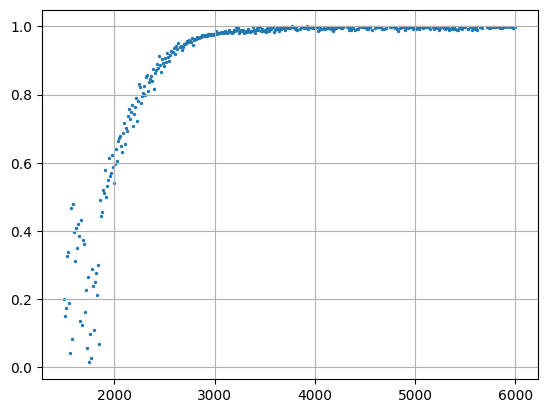

In [199]:
from tensorflow import keras

print(list(PV_total_weight_and_cumper))
x_data = PV_total_weight_and_cumper['Total Weight']
y_data = PV_total_weight_and_cumper['Cumulative Probability']
plt.scatter(x_data, y_data , s=2)
plt.grid()
plt.show()



In [170]:
# Create the model 
model = keras.Sequential()
model.add(keras.layers.Dense(units = 1, activation = 'linear', input_shape=[1]))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 1, activation = 'linear'))
model.compile(loss='mse', optimizer="adam")

# Display the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1)                 2         
                                                                 
 dense_17 (Dense)            (None, 64)                128       
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 1)                

In [ ]:
# Training
model.fit( y_data, x_data, epochs=2000, verbose=1)

12/12 [==============================] - 0s 716us/step


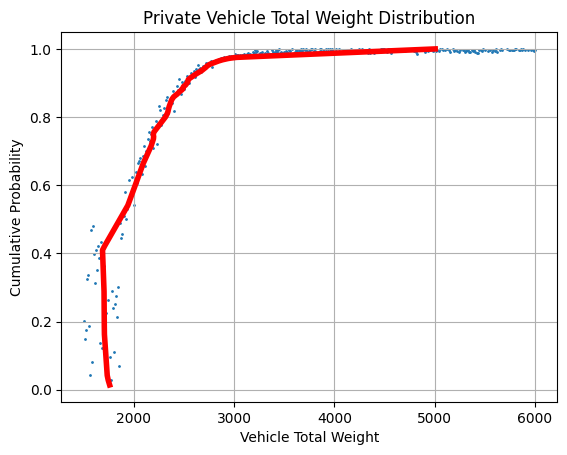

In [179]:
# Compute the output 
x_predicted = model.predict(y_data)

# Display the result
plt.scatter(x_data[::1], y_data[::1], s=1)
plt.plot(x_predicted, y_data, 'r', linewidth=4)
plt.title('Private Vehicle Total Weight Distribution')
plt.xlabel('Vehicle Total Weight')
plt.ylabel('Cumulative Probability')
plt.grid()
plt.show()

In [176]:
total_weight_predicted = model(np.array([0.9999]))
print(total_weight_predicted)

tf.Tensor([[4808.1475]], shape=(1, 1), dtype=float32)


## HDV Weight Distribution. referenced from [Here](https://colab.research.google.com/drive/11A5Td8nxGSbThzL0NPwwv-E5GpBa0Fv9#scrollTo=sMvpBFj5x1L0)

In [210]:
HDV_total_weight_and_cumper = pd.DataFrame(HDV['Total Weight'].value_counts()).reset_index()
HDV_total_weight_and_cumper.columns = ['Total Weight', 'Count']
HDV_total_weight_and_cumper['Percentage'] = HDV_total_weight_and_cumper['Count'] / total_trucks
# Sort it by Weight First or it messes up the Cumu Prob
HDV_total_weight_and_cumper['Cumulative Probability'] = HDV_total_weight_and_cumper['Percentage'].cumsum()


['Total Weight', 'Count', 'Percentage', 'Cumulative Probability']


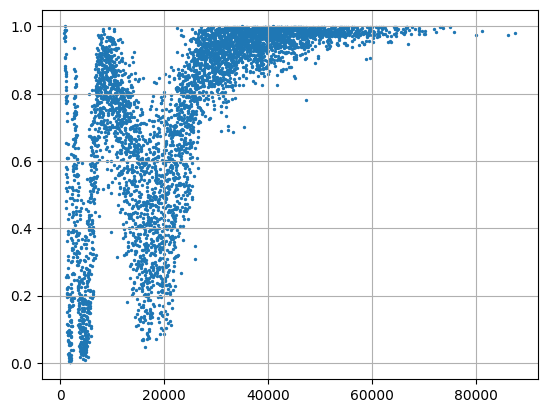

In [208]:
print(list(HDV_total_weight_and_cumper))
x_data = HDV_total_weight_and_cumper['Total Weight']
y_data = HDV_total_weight_and_cumper['Cumulative Probability']
plt.scatter(x_data, y_data , s=2)
plt.grid()
plt.show()